# Ejercicio 2
En este notebook se busca encontrar la distribución de probabilidad del primer momento de falla en el caso de que el proceso sea regenerativo. Para ello se toma el código que entregó el profesor para simular el proceso y se tratará de aplicar el conteo de los pasos que superan el umbral y descartar los que ya lo hicieron en el primer momento.

Además, se deben contar los procesos que pasan por el umbral en un instante dado, y a partir de eso se debe calcular la distribución de probabilidad. Teniendo en cuenta los que pasaron por primera vez para la segunda pasada.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

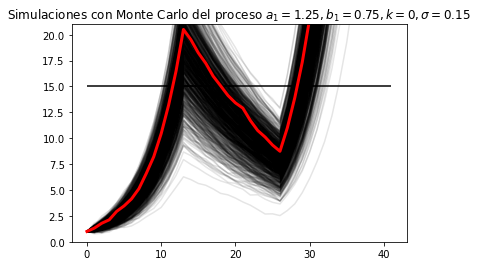

1000.0 1000


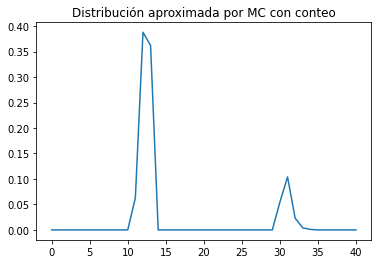

In [61]:
# primero se crea el proceso

x_0 = 1
N = 41

proceso = np.zeros((N,))
proceso[0] = x_0
a1 = 1.25
b1 = 0.75
sigma = 0.15
np.random.seed(32)
u = 15
K = 0

# definicion de las iteraciones de MC
M = 1000
PROCESOS = np.zeros((N,M))
PROCESOS[0, :] = x_0
np.random.seed(42)

cuentas = np.zeros((M,))
histogram_MC = np.zeros((N,))

for i in range(int((N-1) / 3)):
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))
    
    anterior = np.sum(cuentas)
    # sobre el umbral
    checkeo = PROCESOS[i, :] > u
#     print(checkeo)
    cuentas[checkeo] = 1
#     print(cuentas)
    
    histogram_MC[i] = np.sum(cuentas) - anterior
#     print(histogram_MC)
    

for i in range(int((N-1) / 3), int(2 * (N-1) / 3)):
    proceso[i + 1] = K + a1 * b1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * b1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))

    anterior = np.sum(cuentas)
    # sobre el umbral
    checkeo = PROCESOS[i, :] > u
#     print(checkeo)
    cuentas[checkeo] = 1
#     print(cuentas)
    
    histogram_MC[i] = np.sum(cuentas) - anterior
#     print(histogram_MC)

for i in range(int( 2 * (N-1) / 3), int((N-1))):
    proceso[i + 1] = K + a1 * proceso[i] + np.random.normal(0, sigma)
    PROCESOS[i + 1, :] = K + a1 * PROCESOS[i,:] + np.random.normal(0, sigma, size=(M,))
    
    anterior = np.sum(cuentas)
    # sobre el umbral
    checkeo = PROCESOS[i, :] > u
#     print(checkeo)
    cuentas[checkeo] = 1
#     print(cuentas)
    
    histogram_MC[i] = np.sum(cuentas) - anterior
#     print(histogram_MC)

plt.plot(PROCESOS, color='k', alpha=0.1)
plt.plot(proceso, color='r', lw=3)
plt.hlines(u,0,N)
plt.ylim(top=u*1.4, bottom=0)
plt.title('Simulaciones con Monte Carlo del proceso $a_1={}, b_1={}, k={}, \sigma={}$'.format(a1,b1,K,sigma))
plt.show()

print(np.sum(histogram_MC), M)
plt.plot(histogram_MC / np.sum(histogram_MC))
plt.title('Distribución aproximada por MC con conteo')
plt.show()